In [177]:
import os
import cv2 as cv
import glob
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.widgets import Slider
from tqdm import tqdm
# %matplotlib inline
# %matplotlib notebook

In [186]:
left = [cv.imread(file1,cv.IMREAD_GRAYSCALE) for file1 in glob.glob("..\\Desktop\\phone_data\\left\\*.jpg")]
color = [cv.imread(file1) for file1 in glob.glob("..\\Desktop\\phone_data\\left\\*.jpg")]
right = [cv.imread(file2,cv.IMREAD_GRAYSCALE) for file2 in glob.glob("..\\Desktop\\phone_data\\right\\*.jpg")]
chessimg = [cv.imread(file3,cv.IMREAD_GRAYSCALE) for file3 in glob.glob("..\\Desktop\\phone_data\\chessboard\\*.jpg")]
left = left[:20]
right = right[1:21]
color = color[:20]
print(len(left),len(right),len(color),len(chessimg))

20 20 20 47


In [9]:
CHECKERBOARD = (9,6)
criteria = (cv2.TERM_CRITERIA_EPS +
            cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
threedpointsl = []

twodpointsl = []

objectp3dl = np.zeros((1, CHECKERBOARD[0]* CHECKERBOARD[1],3), np.float32)
objectp3dl[0, :, :2] = np.mgrid[0:CHECKERBOARD[0],0:CHECKERBOARD[1]].T.reshape(-1, 2)

prev_img_shape = None
 
for idx in range(len(chessimg)):
    imagel = chessimg[idx]
  
    retl, cornersl = cv2.findChessboardCorners(imagel, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
   
    if retl == True:
        threedpointsl.append(objectp3dl)
   

        corners2l = cv2.cornerSubPix(imagel, cornersl, (11, 11), (-1, -1), criteria)

 
        twodpointsl.append(corners2l)
  
        imagel = cv2.drawChessboardCorners(imagel, CHECKERBOARD, corners2l, retl)
     

h, w = imagel.shape[:2]
 
print(len(threedpointsl),len(twodpointsl))

retl, matrixl, distortionl, r_vecsl, t_vecsl = cv2.calibrateCamera(threedpointsl, twodpointsl, imagel.shape[::-1], None, None)
 
print(" Camera matrix: left")
print(matrixl)
 
print("\n Distortion coefficient: left")
print(distortionl)
 
print("\n Rotation Vectors: left")
print(r_vecsl)
 
print("\n Translation Vectors: left")
print(t_vecsl)


1 1
 Camera matrix: left
[[7.76592170e+03 0.00000000e+00 4.61515747e+02]
 [0.00000000e+00 7.45968744e+03 5.73590046e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

 Distortion coefficient: left
[[ 1.85675533e-01  7.08354026e+01 -6.63999996e-02 -1.23385463e-01
  -3.35334183e+03]]

 Rotation Vectors: left
(array([[-0.38177402],
       [-0.18009506],
       [ 1.64271572]]),)

 Translation Vectors: left
(array([[ 3.53729318],
       [-2.33782627],
       [68.90221829]]),)


Text(0.5, 1.0, 'Right_stereo_image')

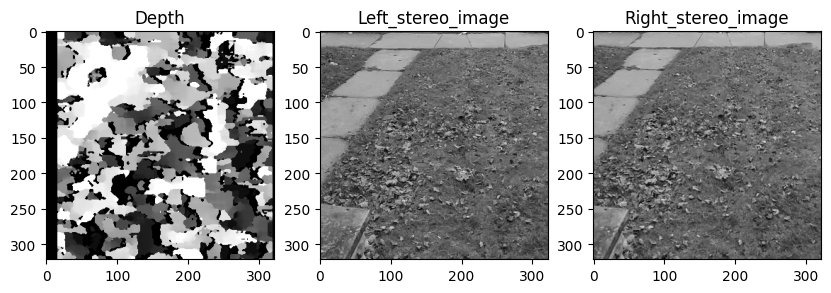

In [192]:
disparity = []
win_size = 5
stereo = cv.StereoSGBM_create(minDisparity=-2,numDisparities=18, blockSize=21, P1 = 8 * 3 * win_size**2, P2 = 32 * 3 * win_size**2)
for i in range(len(left)):
    disparity.append(stereo.compute(left[i],right[i]))
fig = plt.figure(figsize=(10, 7))
rows,columns = 1,3
fig.add_subplot(rows, columns, 1)
plt.imshow(disparity[0],'gray')
plt.title("Depth")
fig.add_subplot(rows, columns, 2)
plt.imshow(left[0],'gray')
plt.title("Left_stereo_image")
fig.add_subplot(rows, columns, 3)
plt.imshow(right[0],'gray')
plt.title("Right_stereo_image")

In [195]:
import json

def feature_extractor(img1,img2): # finding keypoints and descriptors
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    return kp1,kp2,des1,des2

def keypoint_matcher(des1,des2): # my logic for finding which keypoints match from both images
    matches = []
    for i in range(des1.shape[0]):
        thresh = 1000
        for j in range(des2.shape[0]):
            some_value = des1[i] - des2[j]
            some_value = np.linalg.norm(some_value)
#             matches.append((some_value,i,j))
            if thresh > some_value:
                if some_value < 100:
                    min = some_value
                else:
                    min = 2000
                thresh = some_value
                jj = j
                ii = i
        if min != 2000:
            matches.append((min,ii,jj))
              
    matches.sort()
    matches = matches[0:300]
    return matches


def order(imges): # finds if the images match with other images and writing 1 if it does else 0
    g = 0
    f = 0
    length = len(imges)
    overlap_arr = np.zeros((length,length))
    for g in tqdm(range(len(imges))):
        for f in range(len(imges)):
            kp1,kp2,des1,des2 = feature_extractor(imges[g],imges[f])
            matches = keypoint_matcher(des1,des2)

            if len(matches)!= 0:
                x = min(matches)
            if len(matches) > 0 and x[0] < 30:
                overlap_arr[g][f] = 1
            elif len(matches) == 0:
                overlap_arr[g][f] = 0
    return overlap_arr

def get_imaginary_frames(img):
    frame = np.float32(np.array([ [0,0], [0,img.shape[1]], [img.shape[0], img.shape[1]], [img.shape[0],0] ])).reshape((-1,1,2))
    return frame
    

def Calculate_orientation_rotation(keypoint1,keypoint2,img1,img2): # This function finds how to images will be stitched i.e. orienation and translation
    src_pts = np.float32([key_point.pt for key_point in keypoint1]).reshape(-1, 1, 2)
    dst_pts = np.float32([key_point.pt for key_point in keypoint2]).reshape(-1, 1, 2)
    h, _  = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
    imaginary_frame1 = get_imaginary_frames(img1)
    # imaginary frame 1 it just takes the corner of image 1 and makes a imaginary rectangle
    imaginary_frame2 = get_imaginary_frames(img2)
    # imaginary frame 2 it just takes the corner of image 2 and makes a imaginary rectangle
    print(h)
    orient_imaginary_frame2 = cv2.perspectiveTransform(imaginary_frame2, h)
    # orients image 2 w.r.t to image 1
    combine_frame = np.concatenate((imaginary_frame1, orient_imaginary_frame2), axis=0)
    # merges both the imaginary frame
    start_x, start_y = np.int32(combine_frame.min(axis=0).ravel())
    # finds the starting points of second frame after merging
    tanslation_matrix_frame2 = np.array([[1, 0, -start_x], [0, 1, -start_y], [0, 0, 1]])
    # using the formula given in class to make the image matrix with x and y position 
    desired_frame = tanslation_matrix_frame2.dot(h)
    # translates the second image so that it aligns with first image
    return desired_frame,start_y,start_x



def merge_images(img1,img2,disp1,disp2): # simpy pasting the image over the oriented image
    kp1,kp2,des1,des2 = feature_extractor(img1,img2)
    matches = keypoint_matcher(des1,des2)
    keypoint1 = []
    keypoint2 = []
    for i in range(len(matches)):
        y = matches[i][2]
        x = matches[i][1]
        keypoint1.append(kp1[x])
        keypoint2.append(kp2[y])
    desired_frame,start_y,start_x = Calculate_orientation_rotation(keypoint1,keypoint2,img1,img2)
    desired_image = cv2.warpPerspective(img1, desired_frame, (img1.shape[1] + img2.shape[1], img1.shape[0] + img2.shape[0]))
    desired_disp = cv2.warpPerspective(disp1, desired_frame, (img1.shape[1] + img2.shape[1], img1.shape[0] + img2.shape[0]))
    desired_image[-start_y:img2.shape[0]-start_y, -start_x:img2.shape[1]-start_x] = img2
    desired_disp[-start_y:img2.shape[0]-start_y, -start_x:img2.shape[1]-start_x] = disp2
    return desired_image,desired_disp


def stitch(imgs,disp):
    print(len(imgs))
    overlap_arr = order(imgs)
    print(overlap_arr)
    initial_image1 = imgs[1]
    initial_image2 = imgs[0]
    initial_disp1 = disp[1]
    initial_disp2 = disp[0]
    imgs = imgs[1:]
    base_image,base_disp = merge_images(initial_image1,initial_image2,initial_disp1,initial_disp2)
    l = 0
    while l < len(imgs):
        base_image,base_disp = merge_images(base_image,imgs[l],base_disp,disp[l])
        l+=1
    savepath1 = "..\\Desktop\\phone_data\\final.jpg"
    savepath2 = "..\\Desktop\\phone_data\\final_disp.jpg"
    cv2.imwrite(savepath1,base_image)
    cv2.imwrite(savepath2,base_disp)
    return base_image,base_disp


if __name__ == "__main__":
    stitched_image,stitched_disparity = stitch(left[:20],disparity[:20])


20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [28:32<00:00, 85.61s/it]


[[1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.

In [215]:
color = cv2.cvtColor(stitched_image,cv.COLOR_GRAY2RGB)
color = color[:400,:500]
for jdx in range(len(disparity)):
    data = stitched_disparity[:400,:500]
    focal_length = 7.76592170
    q =  np.float32([[1,0,0,0],
                     [0,-1,0,0],
                     [0,0,focal_length*0.05,0],
                     [0,0,0,1]])
    points_3D = cv2.reprojectImageTo3D(data, q)
    mask = data > data.min()
    output_points = points_3D[mask]
    output_colors = color[mask]
    
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(output_points)
pcd.colors = o3d.utility.Vector3dVector(output_colors.astype(np.float) / 255.0)
#     pcd.normals = o3d.utility.Vector3dVector(normals)
o3d.visualization.draw_geometries([pcd])


C:\Users\Neil\AppData\Local\Temp\ipykernel_28240\119293558.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pcd.colors = o3d.utility.Vector3dVector(output_colors.astype(np.float) / 255.0)


[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.



KeyboardInterrupt



In [196]:
print(disparity[0])

[[-48 -48 -48 ... -32 -48 -48]
 [-48 -48 -48 ... -32 -48 -48]
 [-48 -48 -48 ... -32 -48 -48]
 ...
 [-48 -48 -48 ...  98 -48 -48]
 [-48 -48 -48 ...  99 -48 -48]
 [-48 -48 -48 ...  99 -48 -48]]


In [197]:
print(disparity[0][0])

[-48 -48 -48 -48 -48 -48 -48 -48 -48 -48 -48 -48 -48 -48 -48 -48 240 240
 240 240 240 240 240 240 240 240  20  18  18  18  18  17  16  15  14  13
  13  14  15  15  11   7   6   6   4   4   5   9   9   2 -48 -48 -48 -48
 -48 101 101 100 100 102 103 105 105 107 109 110 111 110 109 109 111 112
 112 112 112 -48 -48 -48 -12 -11  -9  -6  -6  -7 -12 -12 -13 -14 -16 -16
 -16 -18 -21 -21 -20 -20 -48 -48 -48 -48 -48 -48 -48 -48 -48 -48 -48 -48
 -48 -48 203 206 207 207 208 208 208 208 208 207 207 207 208 208 209 209
 158 158 158 158 157 157 157 155 155 156 157 158 158 158 158 159 160 160
 162 162 162 161 160 160 160 160 160 160 160 160 160 159 159 159 158 158
 159 159 159 159 159 159 159 159 160 161 163 165 167 168 172 175 176 177
 177 177 178 180 180 -48 -48 -48 -48  81  81  81  16 -32 -32 -48 -48 -48
 -48  26  29  30  32  32  32  32  32  32  32  31  32  31 -32 -48 -48 -48
  14  14  14  14  14  13 -32 -32 -32 -22 -22 -21 -19 -17 -17 -16 -48 -15
 192 192 192 -48 -48 -48 -48 -48 -48 -48 190 191 19

In [201]:
print(left[0][0])

[ 85  75  89  60  53  66  69  78  53  56  34  36  49  48  50  47  58  49
  52  54  46  47  53  48  54  52  56  54  51  46  52  56  65  52  39  58
  53  36  47  49  50  43  37  46  26  41  48  61  58  50  53  50  44  46
  46  44  49  55  64  66  64  71  82  87  83  76  76 101  86  80  85  71
  71  82  90  82  78  87  94  88  88  91  93 101  92  83  83  72  65  70
  65  65  61  47  49  51  61  73  79  43  28  51  54  60  54  40  53  80
  86  83  83  78  84  78  73  68  61  60  69  78  78  75  70  71  74  64
  54  57  43  50  59  71  84  90  89  90  79  76  87  87  76  74  77  78
  96  98  92  92  91  90  85  90  93  90  79  75  86  99  98  90  84  87
  89  73  69  58  60  69  70  72  81  89  98 103 108  88  89  92  92  96
  99  86  80  92  89  83  76  78  97  95  90  91  88  92  95  88  83  95
  89  90  86  96  88  78 107 176  88  97 107 100  88  88  93 103  98  90
  85  96  95  87  82  80  80  85  87  91  87  86  78  86  86  86 100 104
  99 100 104  88  75  82  84  66  68  81  86  89  9

In [202]:
print(right[0][0])

[ 73  73  76  79  79  75  75  77  72  93  72  79  72  90 128 137  91  73
  73  52  97 168 172 195 215 205 132  60  69  66  56  39  65  69  67  65
  61  59  64  63  59  66  63  61  64  60  56  64  77  84  81  78  70  66
  72  67  69  76  72  68  70  73  70  55  47  58  72  74  51  62  79  78
  80  86  85  81  81  77  73  75  84  89  94  99 104 106 100  91  92  90
  93  92  82  75  73  70  71  74  78  78  76  72  68  66  67  75  89  96
  93  96 100  98  89  92  97  98  91  85  91 101  94  93  97 102  98  86
  82  87  91  99 103 100  98 102 107 108 108 110 104  94  91  92  85  74
  77  79  85  97 107  98  95  95 103 116  85  61  58  72  70  73  74  76
  83  71  56  54  52  58  61  52  50  58  63  65  67  69  66  71  66  68
  60 100 175 203 229 235 237 231 221 117  60  90 108 101  95  92  89  89
  99 110 108 109 116 108  95 100 108 110 107 105 115  95  88 101  81  82
  93  82  85  91  87  83  73  78  96  79  71  78  83  78  76  80  73  97
 110 121 115  98  98  99  93 111  94 133 181 166 16

In [207]:
print(stitched_disparity.shape)

(6762, 6762)


In [ ]:
fig = plt.figure(figsize=(5, 5))
rows,columns = 4,5
for i in range(disparity[:20]):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(disparity[i],'gray')
    plt.title("Disparity")

